In [15]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import gradio as gr

In [16]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [17]:
#IMPORT DATA

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", #folder name
     shuffle = True,
     image_size= (IMAGE_SIZE,IMAGE_SIZE),
     batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [18]:
#CHECK CLASSES

class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [19]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)

(32, 256, 256, 3)


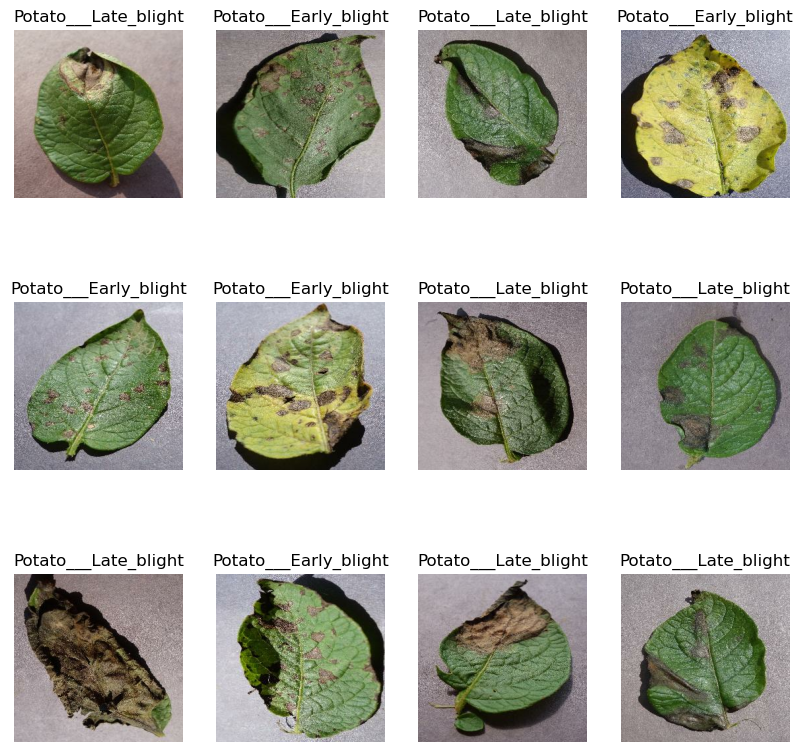

In [20]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
   for i in range(12): 
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
   

In [21]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [22]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [23]:
train_ds = dataset.take(54)
len(train_ds)

54

In [24]:
test_ds = dataset.skip(54) 
len(test_ds)

14

In [25]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [26]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [27]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [28]:
#TRAIN TEST SPLIT

def get_data_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [29]:
train_ds, val_ds, test_ds = get_data_partitions_tf(dataset)

In [30]:
len(train_ds)

54

In [31]:
len(val_ds)

6

In [32]:
len(test_ds)

8

In [33]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [34]:
#supply an image that is not (256,256) and this layer will resize it

resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [35]:
#Data Augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [36]:
#Model Architecture

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape), 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape=input_shape)

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [38]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [39]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/30
54/54 [==============================] - 59s 1s/step - loss: 0.9156 - accuracy: 0.5087 - val_loss: 0.8261 - val_accuracy: 0.6771
Epoch 2/30
54/54 [==============================] - 58s 1s/step - loss: 0.6639 - accuracy: 0.7020 - val_loss: 0.3839 - val_accuracy: 0.8333
Epoch 3/30
54/54 [==============================] - 54s 999ms/step - loss: 0.3613 - accuracy: 0.8542 - val_loss: 0.3075 - val_accuracy: 0.8333
Epoch 4/30
54/54 [==============================] - 54s 1s/step - loss: 0.3552 - accuracy: 0.8513 - val_loss: 0.2251 - val_accuracy: 0.9219
Epoch 5/30
54/54 [==============================] - 54s 1s/step - loss: 0.2261 - accuracy: 0.9045 - val_loss: 0.1465 - val_accuracy: 0.9427
Epoch 6/30
54/54 [==============================] - 54s 1s/step - loss: 0.2321 - accuracy: 0.9080 - val_loss: 0.1766 - val_accuracy: 0.9271
Epoch 7/30
54/54 [==============================] - 55s 1s/step - loss: 0.1868 - accuracy: 0.9225 - val_loss: 0.1622 - val_accuracy: 0.9375
Epoch 8/30
54/54 

In [162]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 201ms/step - loss: 0.1597 - accuracy: 0.9453


In [163]:
scores

[0.15973439812660217, 0.9453125]

In [62]:
history

In [63]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [64]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [65]:
history.history['accuracy']

[0.45891204476356506,
 0.6348379850387573,
 0.8113425970077515,
 0.8530092835426331,
 0.8709490895271301,
 0.9021990895271301,
 0.8929398059844971,
 0.9126157164573669,
 0.9479166865348816,
 0.9276620149612427,
 0.9508101940155029,
 0.96875,
 0.9479166865348816,
 0.9780092835426331,
 0.9456018805503845,
 0.9774305820465088,
 0.9791666865348816,
 0.9635416865348816,
 0.9548611044883728,
 0.9756944179534912,
 0.9837962985038757,
 0.9797453880310059,
 0.9756944179534912,
 0.9780092835426331,
 0.9855324029922485,
 0.984375,
 0.9635416865348816,
 0.9809027910232544,
 0.9866898059844971,
 0.9768518805503845,
 0.9866898059844971,
 0.9872685074806213,
 0.9826388955116272,
 0.9901620149612427,
 0.9918981194496155,
 0.9924768805503845,
 0.9936342835426331,
 0.9849537014961243,
 0.9924768805503845,
 0.9797453880310059,
 0.9901620149612427,
 0.9924768805503845,
 0.9890046119689941,
 0.9780092835426331,
 0.9890046119689941,
 0.9878472089767456,
 0.9890046119689941,
 0.9699074029922485,
 0.991319417

In [66]:
history.history['val_accuracy']

[0.6302083134651184,
 0.765625,
 0.8385416865348816,
 0.8958333134651184,
 0.9322916865348816,
 0.90625,
 0.9114583134651184,
 0.9375,
 0.8802083134651184,
 0.953125,
 0.84375,
 0.828125,
 0.875,
 0.8072916865348816,
 0.8958333134651184,
 0.9583333134651184,
 0.953125,
 0.9375,
 0.984375,
 0.9739583134651184,
 0.984375,
 0.984375,
 0.9947916865348816,
 0.984375,
 0.9895833134651184,
 0.9427083134651184,
 0.96875,
 0.984375,
 0.9947916865348816,
 0.9739583134651184,
 0.9739583134651184,
 0.9895833134651184,
 0.9895833134651184,
 0.9895833134651184,
 0.9895833134651184,
 1.0,
 0.9947916865348816,
 0.9895833134651184,
 0.9947916865348816,
 0.9791666865348816,
 0.9739583134651184,
 0.9791666865348816,
 0.9895833134651184,
 0.9635416865348816,
 0.9947916865348816,
 0.9895833134651184,
 0.9635416865348816,
 0.9895833134651184,
 0.9895833134651184,
 1.0]

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

<function matplotlib.pyplot.show(close=None, block=None)>

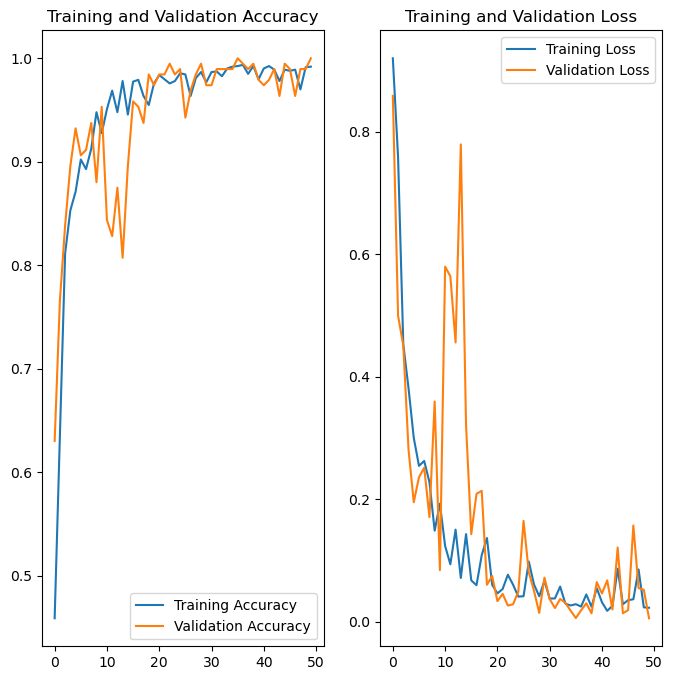

In [68]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 324ms/step
predicted label: Potato___Early_blight


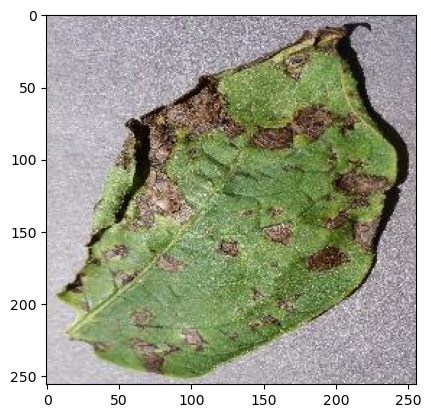

In [69]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [100]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 27ms/step


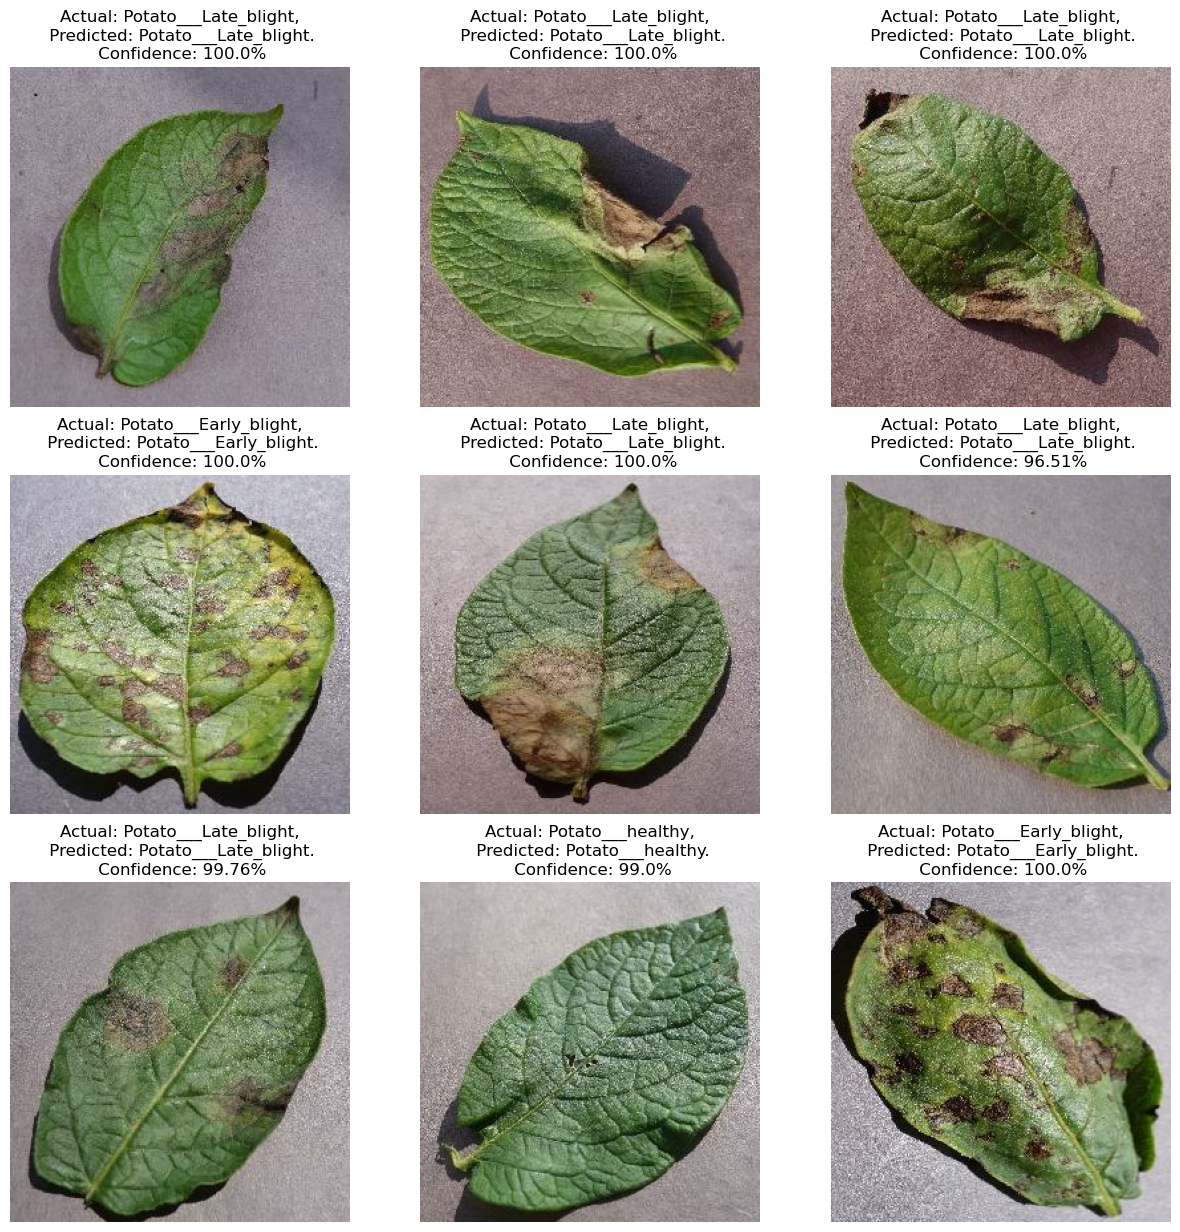

In [101]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [102]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [164]:
def classify_image(inp):
  inp = inp.reshape((-1, 224, 224, 3))
  prediction = model.predict(inp).flatten()
  confidences = {class_names[i]: float(prediction[i]) for i in range(3)}
  return confidences

In [166]:
gr.Interface(fn=classify_image,
             inputs=gr.Image(shape=(224, 224)),
             outputs=gr.Label(num_top_classes=3)).launch()#(share=True)

Running on local URL:  http://127.0.0.1:7881

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 303ms/step
